Training with Harmony only as target -> Output dimension is reduced to 12

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

import math
import numpy as np

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import random

# Check if GPU is available, set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [2]:
sos_token = np.full((1, 24), 1)
pad_token = np.full((1, 24), 2)
pad_token = torch.tensor(pad_token, device=device)

dataset_dir = "/home/falaxdb/Repos/minus1/datasets/maestro_v3_split/hands_split_into_seperate_midis"
snapshot_intervall = 0.05

# Define other parameters
batch_size = 64
seq_length = 512
stride = 256

test_size=0.3

In [3]:
from transformer_decoder_training.dataprep_transformer.prepare_dataloader_complete import prepare_dataset_as_dataloaders

# Load Data

train_loader, val_loader, test_loader = prepare_dataset_as_dataloaders(dataset_dir, snapshot_intervall, batch_size, seq_length, stride, test_size, sos_token)

Processed dataset (1038/1038): 100%|██████████| 1038/1038 [00:14<00:00, 71.16it/s]


Processed 1038 of 1038 files


In [4]:
# set parameters
# Learning rate for the optimizer
learning_rate = 1e-3
# Number of epochs for training
num_epochs = 20
# basically input dimension before embedding
num_emb = 24
# output dimension
num_output_dim = 12
# size after embedding for feed forward neural network
hidden_size = 256
# Number of transformer blocks
num_layers = 8
# MultiheadAttention Heads
num_heads = 8

In [5]:
from transformer_decoder_training.models.transformer_decoder_2 import Transformer

model = Transformer(num_emb=num_emb, num_layers=num_layers, hidden_size=hidden_size, num_heads=num_heads, num_output_dim=num_output_dim).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
# loss function should be one that can handle multi one hot encoded vectors
# Klammern nicht vergessen
# Chat gpt says BCEWithLogitsLoss is more stable
loss_fn = nn.BCEWithLogitsLoss()

In [6]:
# Prepare directory for saving model state dict, parameters, loss, etc.
# leave out ".pth"
model_state_dict_filepath = "/home/falaxdb/Repos/minus1/transformer_decoder_training/saved_files/saved_models/model_1_notebook_v6.3"

Epoch: 1, Train loss: 0.224, Val loss: 0.136, Epoch time = 43.600s


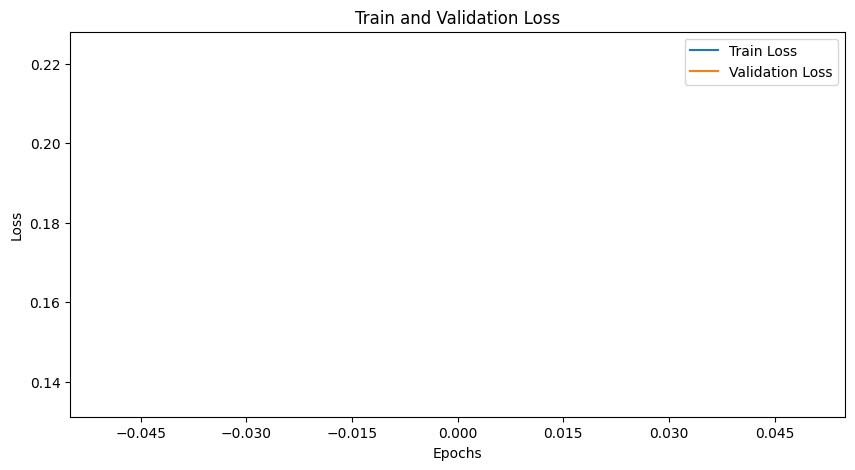

Epoch: 2, Train loss: 0.141, Val loss: 0.132, Epoch time = 43.453s


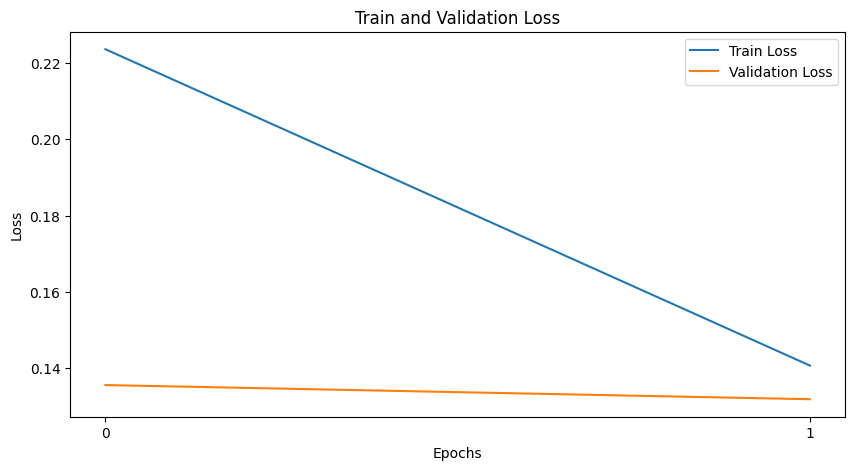

Epoch: 3, Train loss: 0.137, Val loss: 0.128, Epoch time = 42.549s


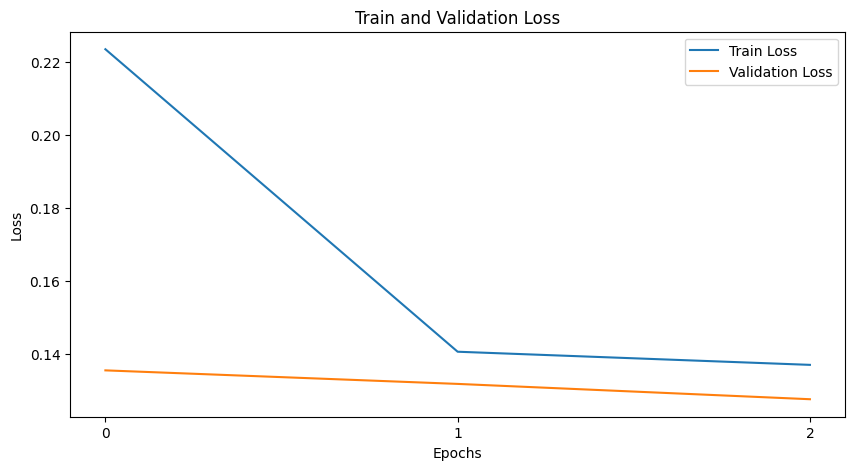

Epoch: 4, Train loss: 0.134, Val loss: 0.125, Epoch time = 41.398s


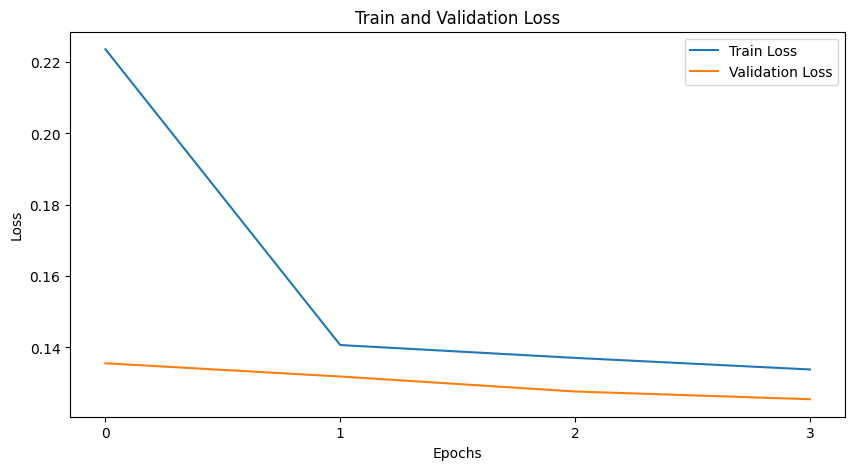

Epoch: 5, Train loss: 0.132, Val loss: 0.124, Epoch time = 41.404s


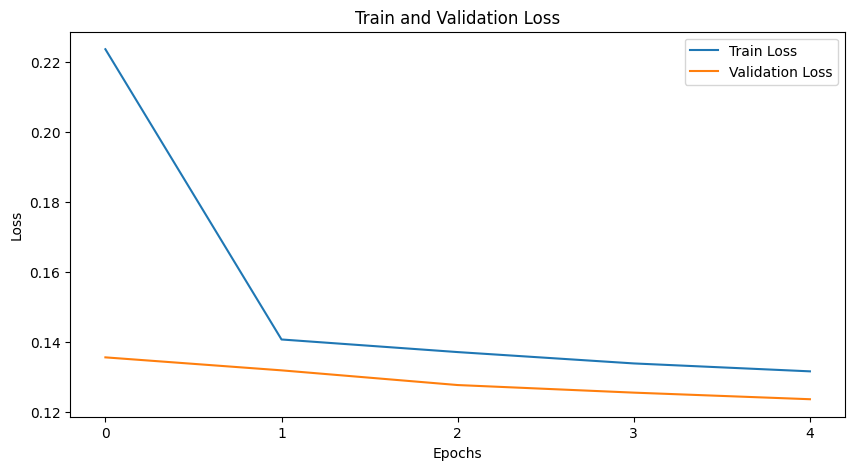

Epoch: 6, Train loss: 0.130, Val loss: 0.122, Epoch time = 41.466s


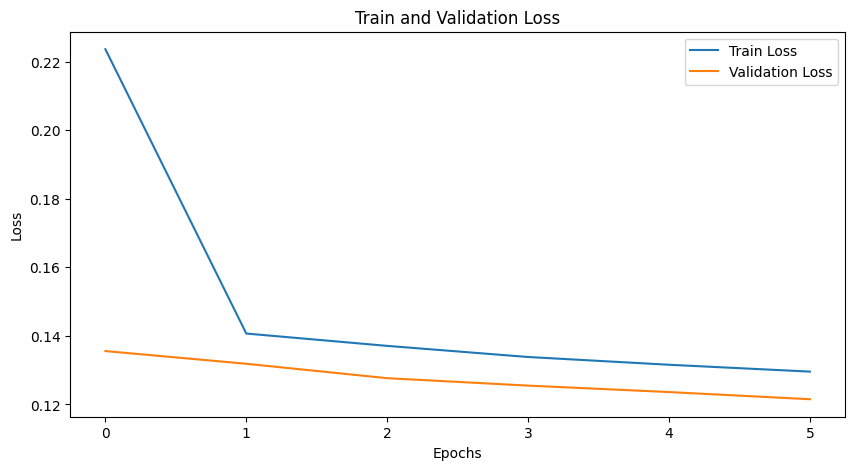

Epoch: 7, Train loss: 0.128, Val loss: 0.120, Epoch time = 41.716s


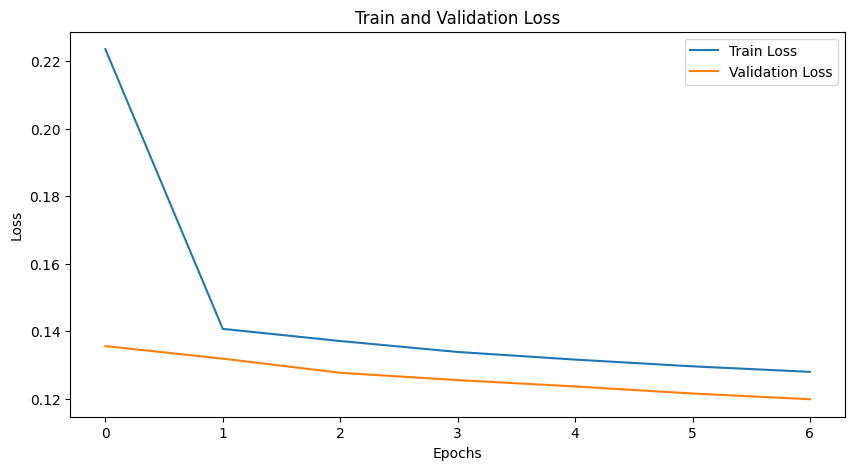

Epoch: 8, Train loss: 0.126, Val loss: 0.118, Epoch time = 41.352s


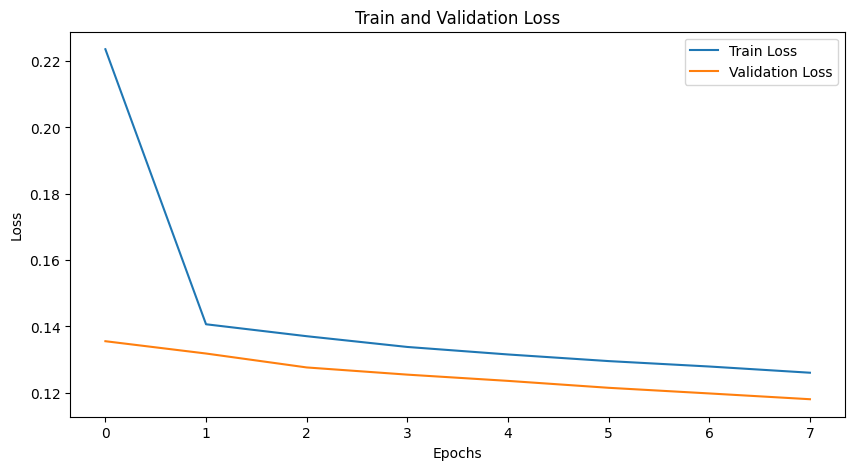

Epoch: 9, Train loss: 0.124, Val loss: 0.116, Epoch time = 41.465s


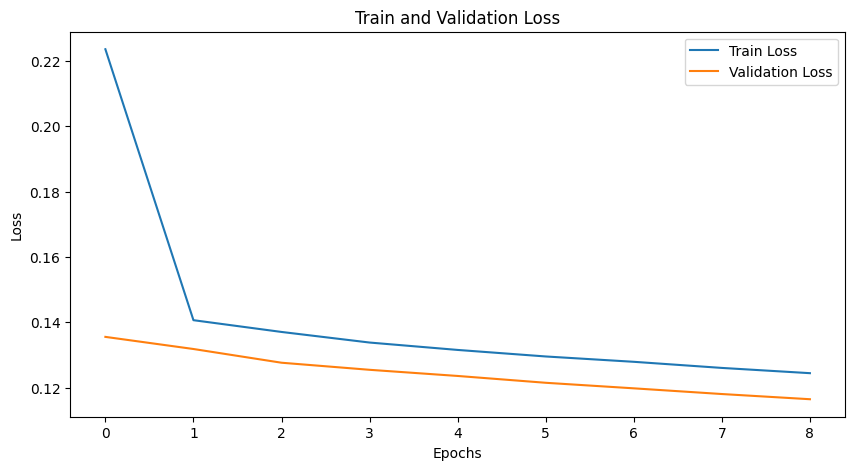

Epoch: 10, Train loss: 0.123, Val loss: 0.115, Epoch time = 41.393s


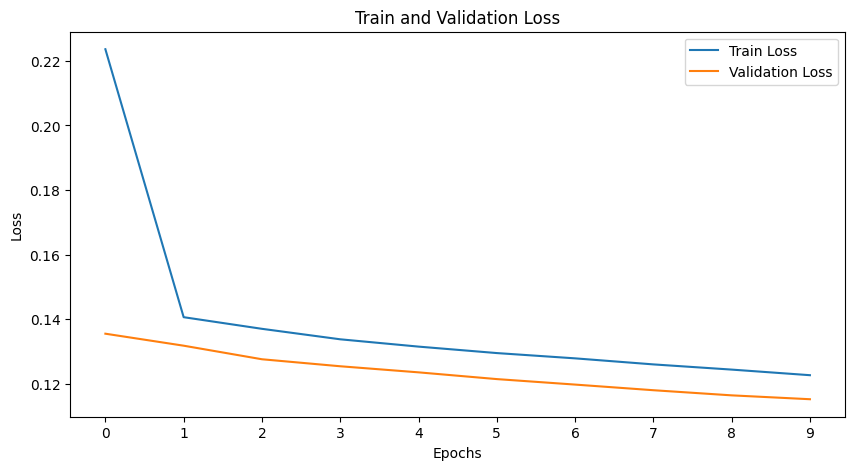

Epoch: 11, Train loss: 0.121, Val loss: 0.114, Epoch time = 41.301s


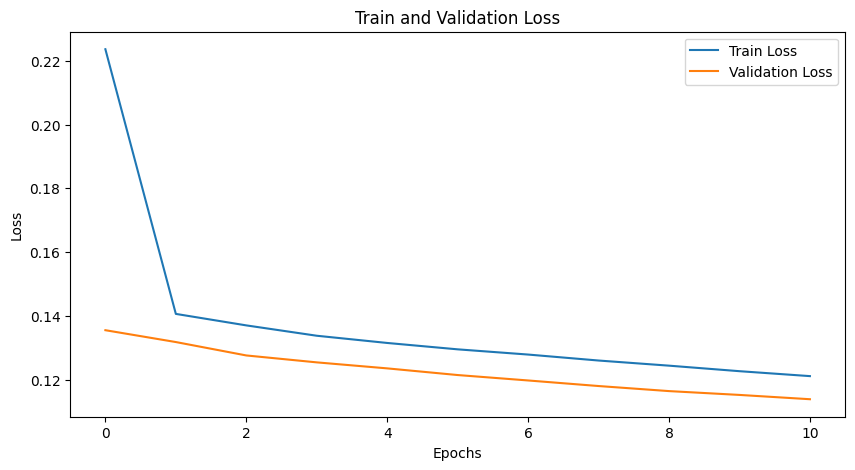

Epoch: 12, Train loss: 0.120, Val loss: 0.113, Epoch time = 41.248s


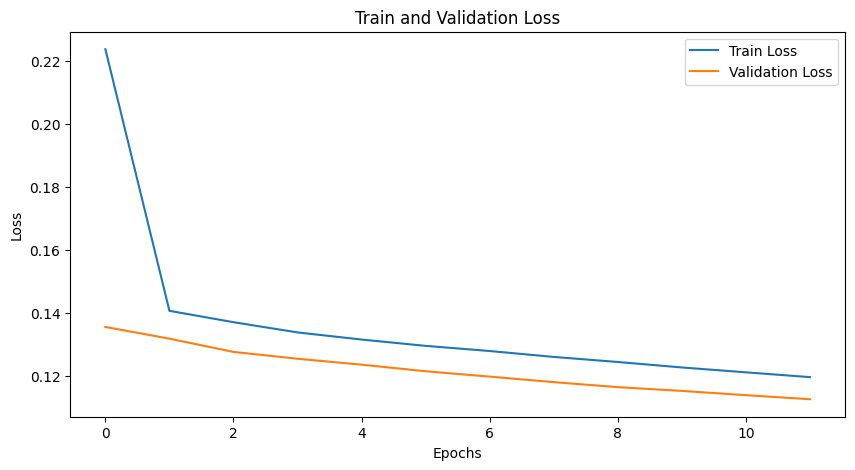

Epoch: 13, Train loss: 0.118, Val loss: 0.112, Epoch time = 41.274s


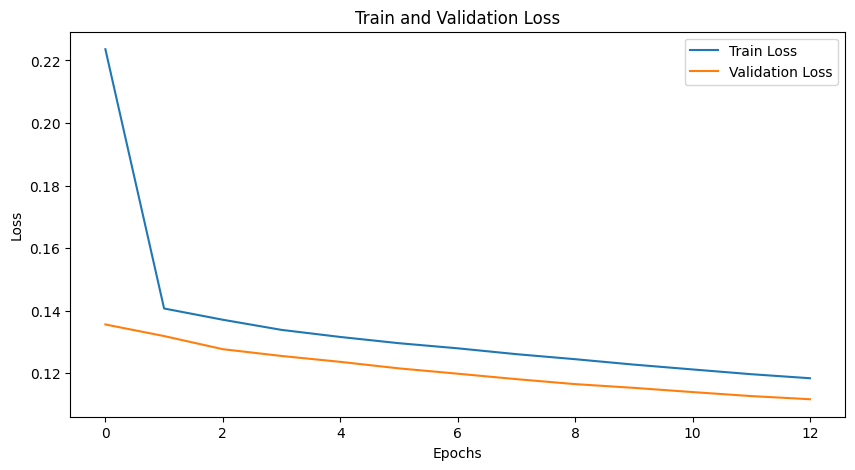

Epoch: 14, Train loss: 0.117, Val loss: 0.111, Epoch time = 41.364s


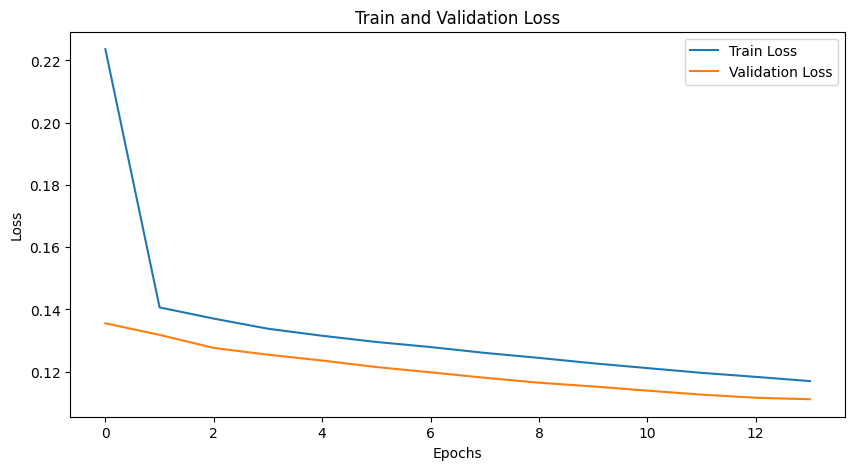

Epoch: 15, Train loss: 0.116, Val loss: 0.111, Epoch time = 41.368s


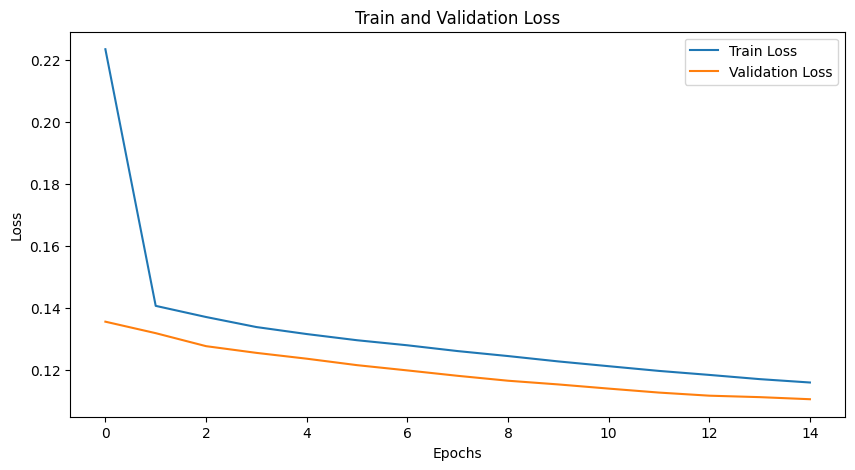

Epoch: 16, Train loss: 0.115, Val loss: 0.110, Epoch time = 41.337s


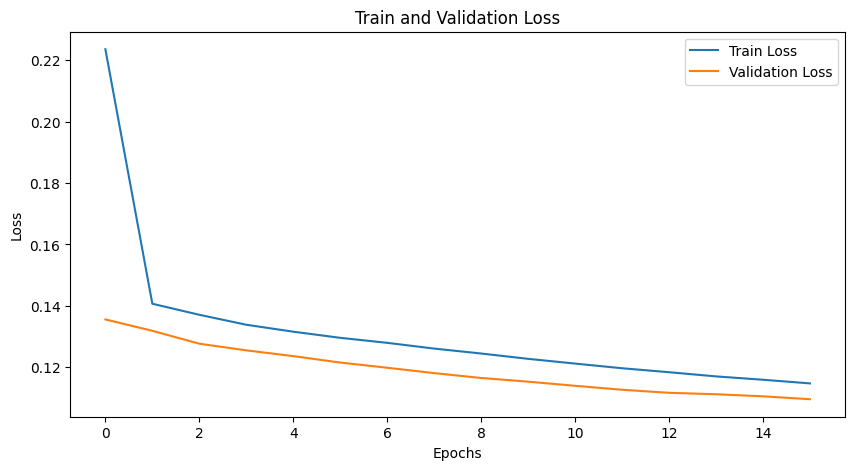

Epoch: 17, Train loss: 0.114, Val loss: 0.109, Epoch time = 41.288s


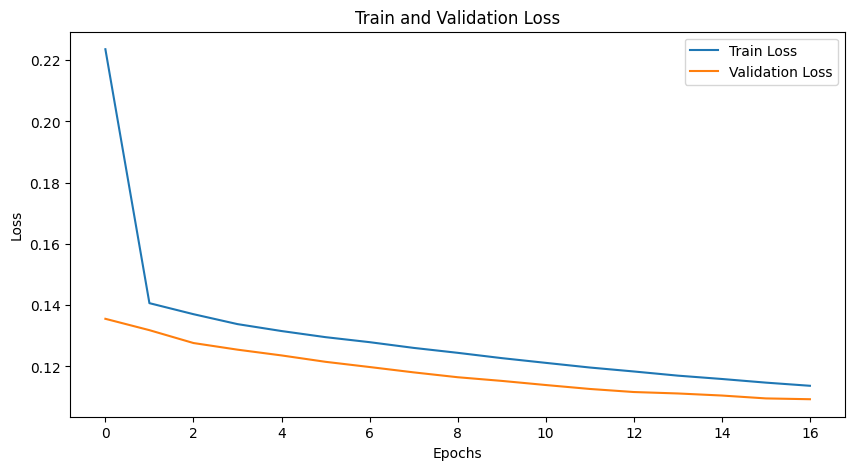

Epoch: 18, Train loss: 0.113, Val loss: 0.109, Epoch time = 41.311s


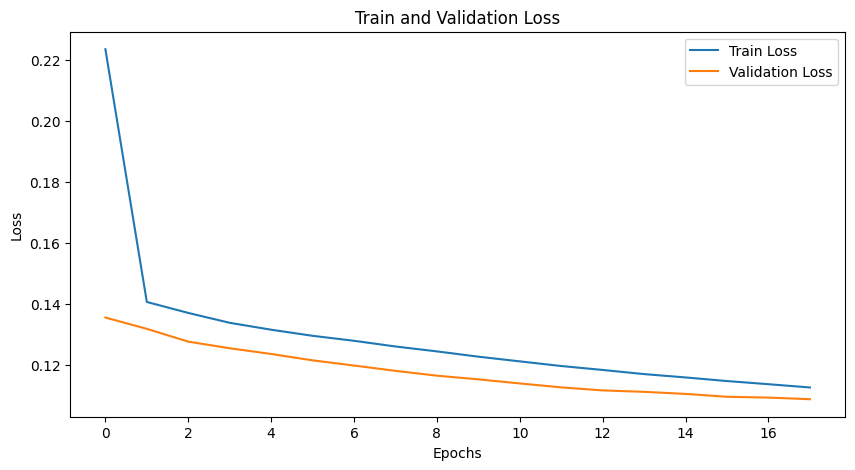

Epoch: 19, Train loss: 0.112, Val loss: 0.108, Epoch time = 41.396s


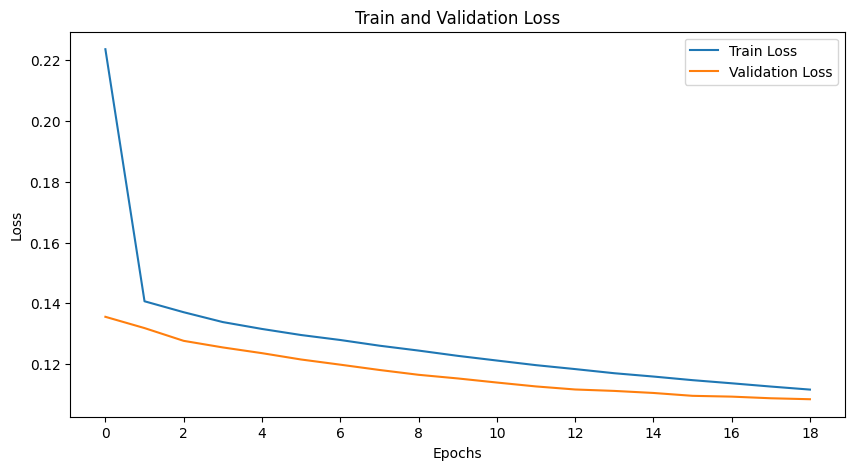

Epoch: 20, Train loss: 0.111, Val loss: 0.108, Epoch time = 41.322s


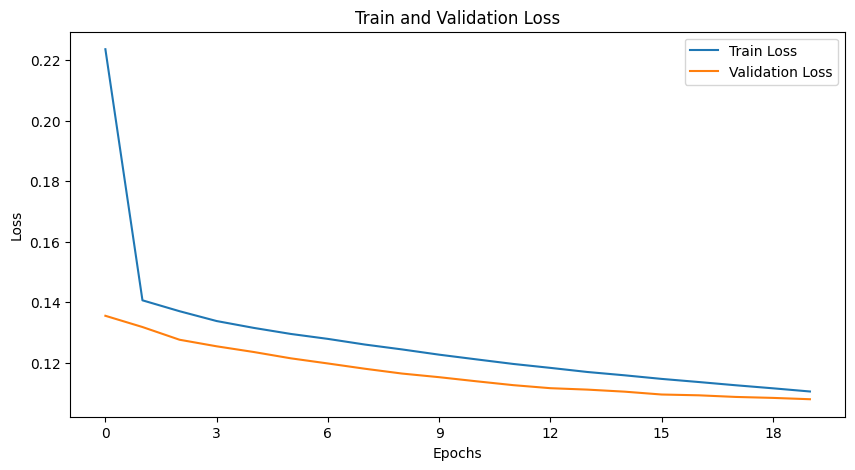

In [7]:
from timeit import default_timer as timer
from transformer_decoder_training.training import training_1
from IPython.display import clear_output
from data_visualization.Visualization import plot_losses

# Initialize lists to store loss values
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    start_time = timer()
    train_loss = training_1.train_loop_harmony_only(model, optimizer, loss_fn, train_loader, pad_token, device)
    end_time = timer()
    val_loss = training_1.validation_loop_harmony_only(model, loss_fn, val_loader, pad_token, device)
    
    # Store the loss values
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    
    plot_losses(train_losses, val_losses, model_state_dict_filepath + "loss_plot.png")

In [8]:
import json


torch.save(model.state_dict(), model_state_dict_filepath + ".pth")
# save the parameters
model_params = {
    "model_topology": str(model),
    "num_emb": num_emb,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "num_heads": num_heads,
    "training_params": {
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "optimizer": optimizer.__class__.__name__,
        "loss_fn": loss_fn.__class__.__name__
    },
    "training_data_params": {
        "sos_token": sos_token.tolist(),
        "pad_token": pad_token.tolist(),
        "snapshot_intervall": snapshot_intervall,
        "batch_size": batch_size,
        "sequence_length": seq_length,
        "stride": stride
    }
}

# Save the model parameters separately as a JSON file
params_path = model_state_dict_filepath + "_model_params.json"
with open(params_path, 'w') as f:
    json.dump(model_params, f)